In [1]:
import pandas as pd 
import numpy as np
import math 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim

import pickle 
import main
from main import add_noise
from main import denoise
from main import get_data

/Users/simonpallesen/.pyenv/versions/3.9.1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using cpu device


In [2]:
with open('data/sampled_filters_train.pkl', 'rb') as f:
    data = pickle.load(f)

filter_wls, wavelengths, spectra, X, X_normalized, y, z = get_data(data)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [8]:
model_big = main.BigUNet().double().to(device)
model_big.load_state_dict(torch.load('../runs1/model_param_model_big.pt', map_location=torch.device('cpu')))

model_medBig = main.MedBigUNet().double().to(device)
model_medBig.load_state_dict(torch.load('../runs1/model_param_model_medBig.pt', map_location=torch.device('cpu')))

model_medium = main.MediumUNet().double().to(device)
model_medium.load_state_dict(torch.load('../runs1/model_param_model_medium.pt', map_location=torch.device('cpu')))

model_small = main.SmallUNet().double().to(device)
model_small.load_state_dict(torch.load('../runs1/model_param_model_small.pt', map_location=torch.device('cpu')))

modelList = [model_big, model_medBig, model_medium, model_small]
modelNames = ["model_big", "model_medBig", "model_medium", "model_small"]


In [13]:
model_big()

30

Denoise

ValueError: x and y must be the same size

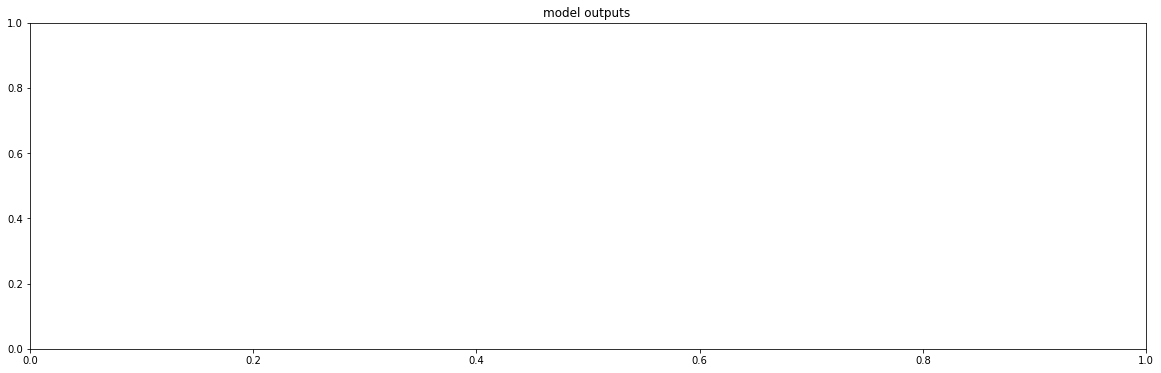

In [9]:
mu, sigma = np.zeros(31), np.identity(31)
X_T = np.random.multivariate_normal(mu, sigma)
#denoise_big = denoise(modelList[0], X_T).cpu().detach()
#denoise_medBig = denoise(modelList[1], X_T).cpu().detach()
#denoise_medium = denoise(modelList[2], X_T).cpu().detach()
#denoise_small = denoise(modelList[3], X_T).cpu().detach()

plt.figure(figsize= (20, 6))

for i in range(4):
    plt.subplot(1, 1, 1)
    plt.title('model outputs ')
    plt.scatter(filter_wls, denoise(modelList[i], X_T).cpu().detach(), label = modelNames[i])
plt.ylabel("magnitude")
plt.ylim(-2, 2)
plt.xlabel("wavelength")
plt.legend()

#plt.savefig('data/foo.png')

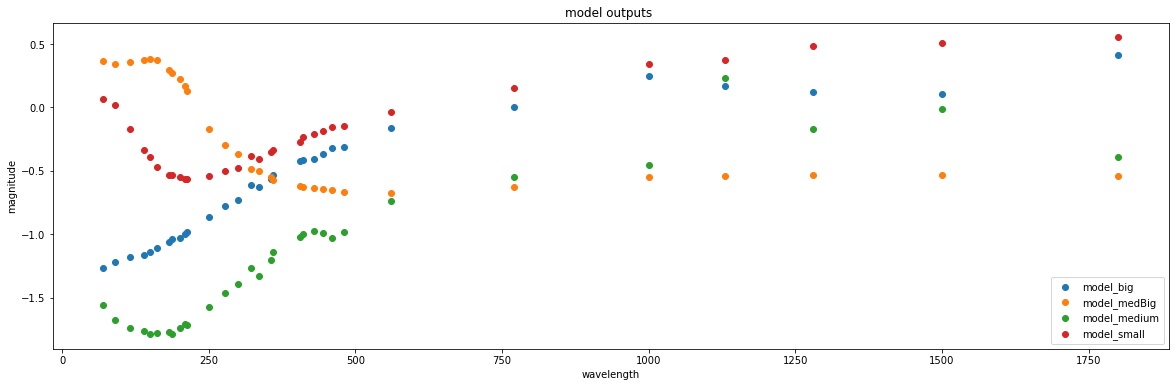

In [7]:
plt.figure(figsize= (20, 6))

for i in range(4):
    plt.subplot(1, 1, 1)
    plt.title('model outputs ')
    plt.scatter(filter_wls, X_normalized[np.random.randint(0, 100)], label = modelNames[i])
plt.ylabel("magnitude")
#plt.ylim(30,10)
plt.xlabel("wavelength")
plt.legend()

#plt.savefig('data/foo.png')

In [134]:
def cos_betaAlpha_schedule(T = 300, s=0.005):

    x = torch.linspace(0, T, T+1)
    alphas_cumprod = torch.cos(((x / T) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    betas = torch.clip(betas, 0.0001, 0.9999)
    alpha_bar = np.cumprod(np.array([1-betas[i] for i in range(len(betas))]))
    return betas, alpha_bar

def add_noise(X, t, beta_t, alpha_bar):
    if t == 0:
        X_tm1 = X
    else:
        mu, sigma = math.sqrt(alpha_bar[t - 1]) * X, (1 - alpha_bar[t - 1]) * np.identity(len(X))
        X_tm1 = np.random.multivariate_normal(mu, sigma)
    mu, sigma = math.sqrt(1 - beta_t[t]) * X_tm1, (beta_t[t]) * np.identity(len(X_tm1))
    X_t = np.random.multivariate_normal(mu, sigma)
    pred_noise =  X_t - X_tm1
    return X_t, pred_noise

d:\simon\Anaconda\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1, 1, 31])) that is different to the input size (torch.Size([31])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


loss:  tensor(0.0036)


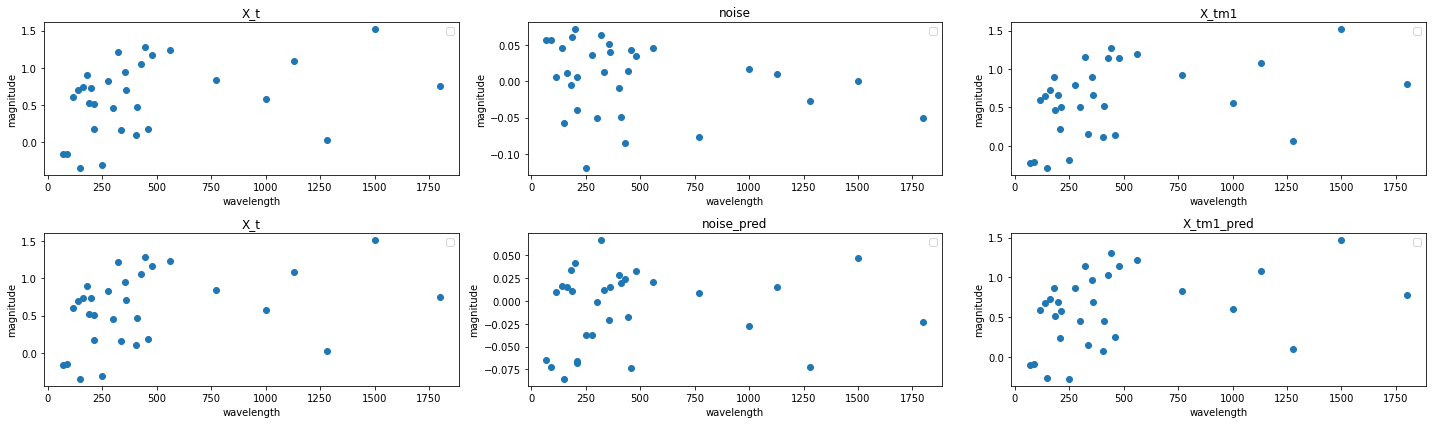

In [138]:
beta_t, alpha_bar = cos_betaAlpha_schedule()
model = model_big
p1 = random.randint(0, 100)

X_t, noise = add_noise(X_normalized[0], 80, beta_t, alpha_bar)
X_tm1 = np.array(X_t) - np.array(noise)

noise_pred = model(torch.tensor(X_t).unsqueeze(0).unsqueeze(0).to(device)).cpu().detach().numpy()
X_tm1_pred = np.array(X_t) - noise_pred

loss_fn = nn.MSELoss()
loss = loss_fn(torch.tensor(noise).float(), torch.tensor(noise_pred).float())
print("loss: ", loss)


plt.figure(figsize= (20, 6))
names = ["X_t", "noise", "X_tm1", "X_t", "noise_pred", "X_tm1_pred"]
for i, d in enumerate([X_t, noise, X_tm1, X_t, noise_pred, X_tm1_pred]):
    plt.subplot(2, 3, i +1)
    plt.title(names[i])
    plt.scatter(filter_wls, d)
    plt.ylabel("magnitude")
    #plt.ylim(30,10)
    plt.xlabel("wavelength")
    plt.legend()

plt.tight_layout()
plt.show()


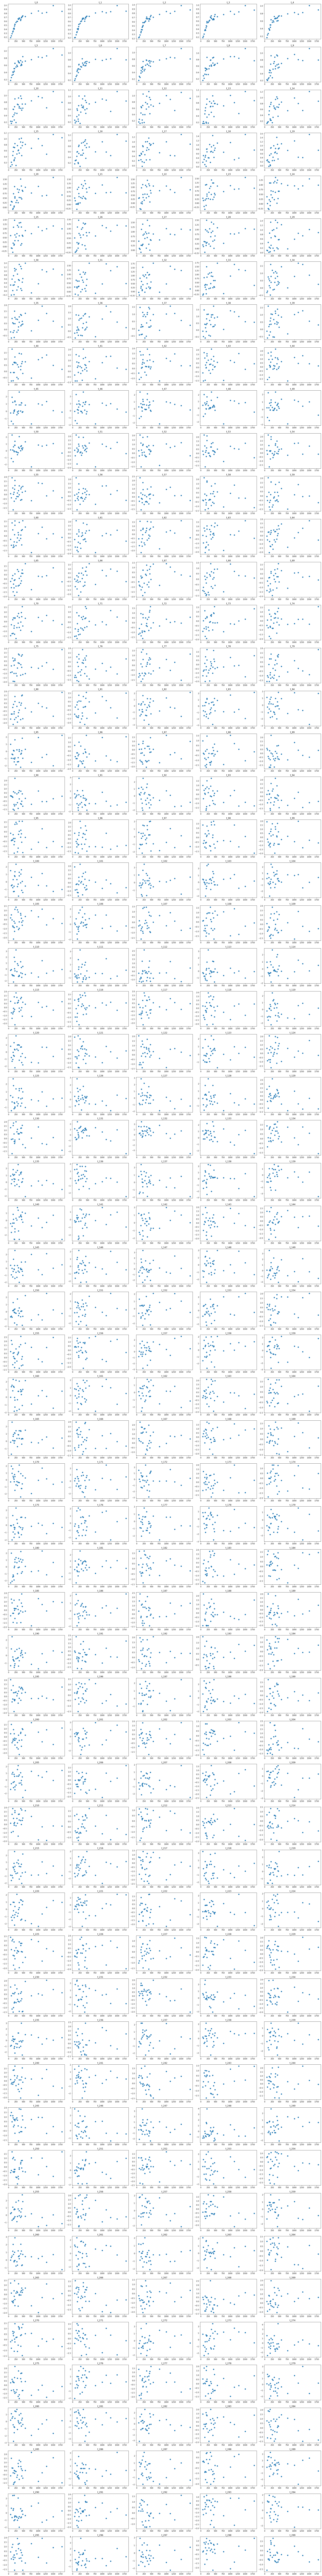

In [125]:
T = 300
beta_t, alpha_bar = cos_betaAlpha_schedule(T = T)


X_t = X_normalized[0]

plt.figure(figsize= (25, 200))
for t in range(300):
    plt.subplot(60, 5, t + 1)
    plt.title("t_" + str(t))
    plt.scatter(filter_wls, X_t)
    X_t, noise = add_noise(X_t, t, beta_t, alpha_bar)
plt.tight_layout()
plt.show()


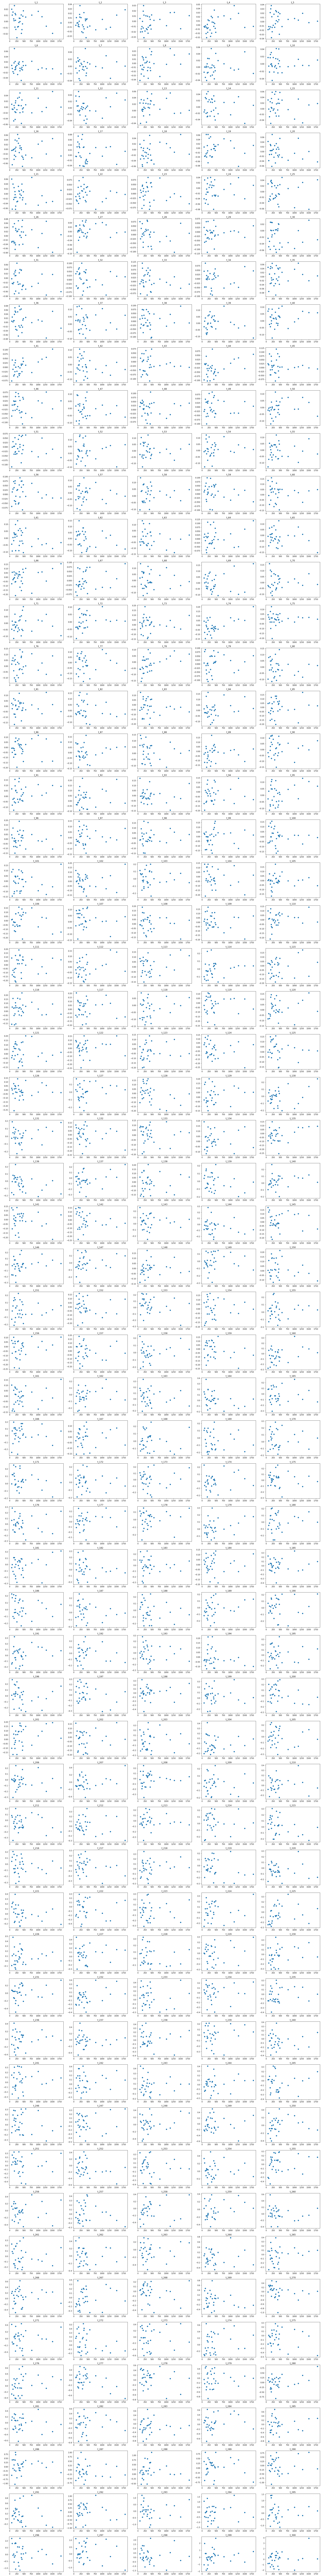

In [126]:
T = 300
beta_t = cos_beta_schedule(T = T)
alpha_bar = np.cumprod(np.array([1-beta_t[i] for i in range(len(beta_t))]))

X_t = X_normalized[0]

plt.figure(figsize= (25, 200))
for t in range(300):
    X_t, noise = add_noise(X_t, t, beta_t, alpha_bar)
    plt.subplot(60, 5, t + 1)
    plt.title("t_" + str(t + 1))
    plt.scatter(filter_wls, noise)
plt.tight_layout()
plt.show()

In [128]:
np.mean(np.random.normal(X_t))

0.18430832658017